In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns


In [2]:
def joint_entropies(data, nbins=None):
    n_variables = data.shape[-1]
    n_samples = data.shape[0]
    if nbins == None:
        nbins = int((n_samples/5)**.5)
    histograms2d = np.zeros((n_variables, n_variables, nbins, nbins))
    for i in range(n_variables):
        for j in range(n_variables):
            histograms2d[i,j] = np.histogram2d(data[:,i], data[:,j], bins=nbins)[0]
    probs = histograms2d / len(data) + 1e-100
    joint_entropies = -(probs * np.log2(probs)).sum((2,3))
    return joint_entropies

def mutual_info_matrix(df, nbins=None, normalized=True):
    data = df.to_numpy()
    n_variables = data.shape[-1]
    j_entropies = joint_entropies(data, nbins)
    entropies = j_entropies.diagonal()
    entropies_tile = np.tile(entropies, (n_variables, 1))
    sum_entropies = entropies_tile + entropies_tile.T
    mi_matrix = sum_entropies - j_entropies
    if normalized:
        mi_matrix = mi_matrix * 2 / sum_entropies    
    return pd.DataFrame(mi_matrix, index=df.columns, columns=df.columns)

Shapes:
(200000, 10, 15, 2) (200000, 300) (200000, 304) (200000, 306)

PCA Variances:
[8.76e-01 1.03e-01 1.10e-02 3.79e-03 3.02e-03 8.33e-04 5.08e-04 4.59e-04
 2.61e-04 9.17e-05] [9.91e-01 8.55e-03 1.22e-04 2.76e-06 7.51e-10 8.80e-11 8.91e-12 2.69e-12
 2.43e-12 7.17e-13] [9.88e-01 8.52e-03 3.06e-03 4.90e-04 1.22e-04 2.75e-06 3.07e-10 3.20e-11
 8.23e-12 1.57e-12]


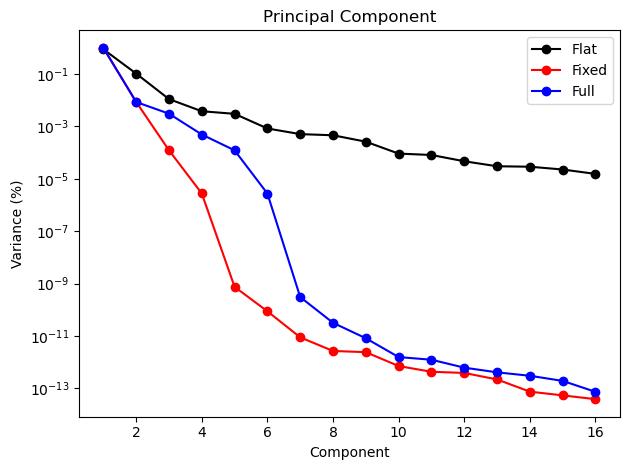

In [3]:
theta = np.load('../data/run2/theta.npy')[:,:6] #[Om, s8, w, n_s, Ob, H0, ia , dnz1, dnz2, dnz3, dnz4, mpb1, mpb2, mpb3, mpb4, id]
theta_fixed = theta[:,2:]
theta = theta[:,:2]

xip = np.load('../data/run2/xip.npy')
xim = np.load('../data/run2/xim.npy')

xi = np.concatenate((xip[:,:,:,None], xim[:,:,:,None]), axis=3)
xi_flat = xi.reshape(xi.shape[0], -1)
xi_fixed = np.concatenate((xi_flat, theta_fixed), axis=1)
xi_full = np.concatenate((xi_flat, theta, theta_fixed), axis=1)

print("Shapes:")
print(xi.shape, xi_flat.shape, xi_fixed.shape, xi_full.shape)

n_components = 16
pca_flat = PCA(n_components=n_components, svd_solver='full')
pca_fixed = PCA(n_components=n_components, svd_solver='full')
pca_full = PCA(n_components=n_components, svd_solver='full')

pca_flat.fit(xi_flat)
pca_fixed.fit(xi_fixed)
pca_full.fit(xi_full)

xi_flat_pca = pca_flat.transform(xi_flat)
xi_fixed_pca = pca_fixed.transform(xi_fixed)
xi_full_pca = pca_full.transform(xi_full)

var_flat = pca_flat.explained_variance_ratio_
var_fixed = pca_fixed.explained_variance_ratio_
var_full = pca_full.explained_variance_ratio_


print("\nPCA Variances:")
print(np.array_str(var_flat[:min(10, n_components)], precision=2), np.array_str(var_fixed[:min(10, n_components)], precision=2), np.array_str(var_full[:min(10, n_components)], precision=2))

plt.plot(np.arange(1,n_components+1), var_flat, 'o-', c='k', label='Flat')
plt.plot(np.arange(1,n_components+1), var_fixed, 'o-', c='r', label='Fixed')
plt.plot(np.arange(1,n_components+1), var_full, 'o-', c='b', label='Full')
plt.yscale('log')
plt.legend()
plt.title('Principal Component')
plt.xlabel('Component')
plt.ylabel('Variance (%)')
plt.tight_layout()

# PCA

Text(0.5, 1.0, 'Full')

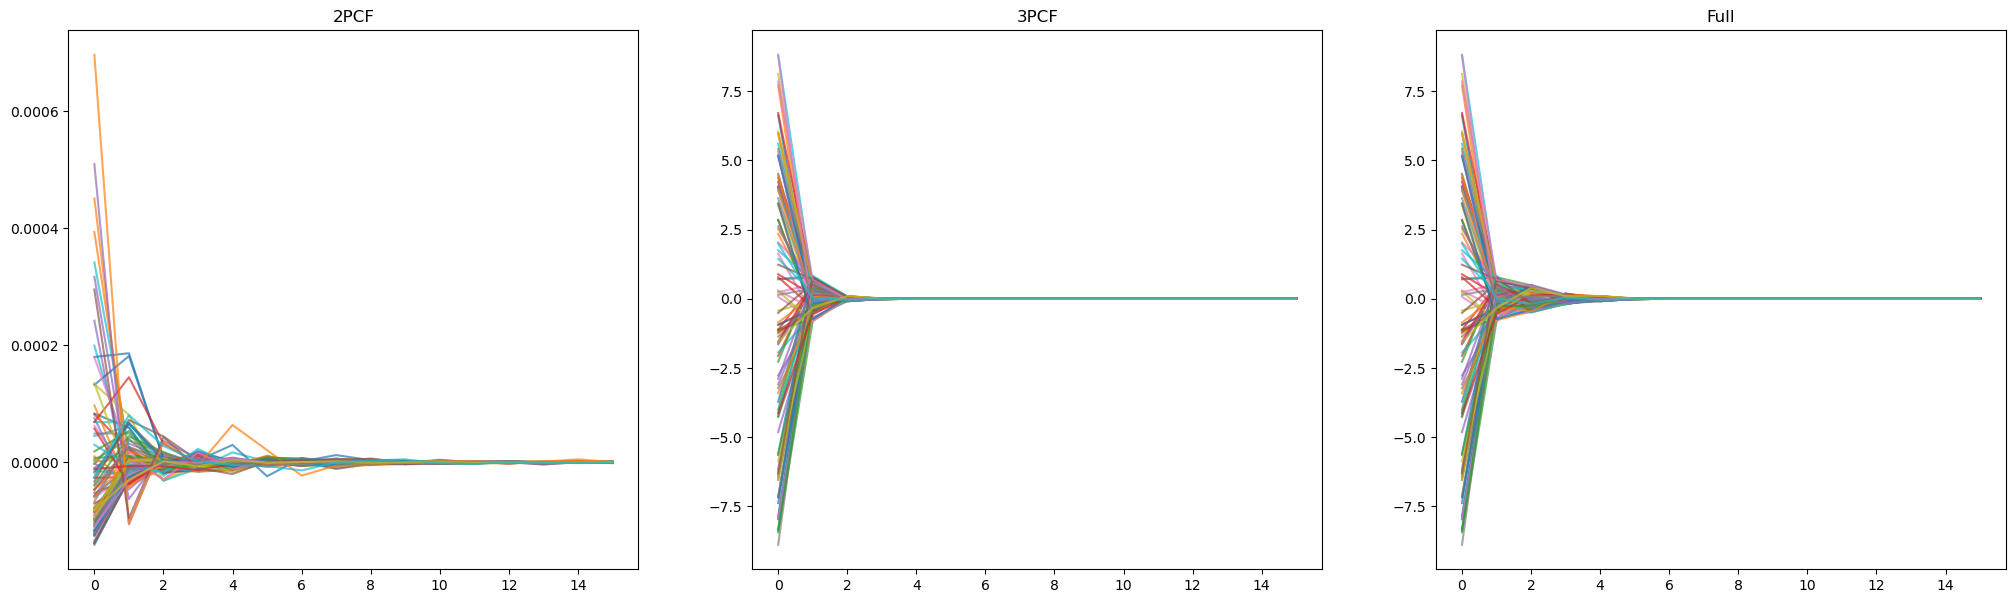

In [4]:
maxind = min(16, n_components)
fig, ax = plt.subplots(1,3, figsize=(25,7))

for i in range(100):
    ax[0].plot(xi_flat_pca[i][:maxind], alpha=.7)
    ax[1].plot(xi_fixed_pca[i][:maxind], alpha=.7)
    ax[2].plot(xi_full_pca[i][:maxind], alpha=.7)

ax[0].set_title('2PCF')
ax[1].set_title('3PCF')
ax[2].set_title('Full')
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')

# Correlations

In [5]:
df_flat = pd.DataFrame(np.concatenate([theta, theta_fixed, xi_flat_pca[:,:10]], axis=1))
df_flat.columns = ['Omega_m', 'sigma_8', 'w', 'n_s', 'Omega_b', 'H0'] + ['PC_'+str(i+1) for i in range(10)]

df_flat.corr('pearson').style.format('{:.3e}').background_gradient(cmap='coolwarm', vmin=-10, gmap=np.log10(np.abs(np.corrcoef(df_flat.T))), axis=None)

,Omega_m,sigma_8,w,n_s,Omega_b,H0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
Omega_m,1.000e+00,-5.128e-04,1.234e-03,-1.882e-03,-6.807e-04,3.484e-03,4.417e-01,1.830e-01,2.182e-01,-5.257e-01,8.281e-02,-1.737e-01,1.287e-01,5.086e-02,-1.048e-01,-4.915e-03
sigma_8,-5.128e-04,1.000e+00,6.959e-05,-2.916e-04,3.154e-04,-5.028e-04,6.630e-01,4.146e-01,-1.498e-01,2.287e-01,-3.393e-01,1.371e-01,-1.364e-01,-9.844e-02,3.987e-02,-5.384e-02
w,1.234e-03,6.959e-05,1.000e+00,2.755e-03,2.408e-03,6.715e-04,-8.512e-02,-1.177e-01,2.398e-01,-1.690e-01,-1.259e-01,-2.193e-02,-1.163e-01,-7.035e-02,-1.062e-01,-2.477e-01
n_s,-1.882e-03,-2.916e-04,2.755e-03,1.000e+00,-1.523e-04,8.291e-04,-3.818e-02,-3.771e-02,7.694e-02,-3.150e-01,-1.232e-01,4.882e-02,-1.961e-02,2.375e-02,-7.240e-02,-2.782e-02
Omega_b,-6.807e-04,3.154e-04,2.408e-03,-1.523e-04,1.000e+00,5.983e-05,1.402e-02,1.830e-02,-4.502e-02,1.846e-01,-5.056e-02,-1.877e-02,-4.400e-02,-6.228e-02,5.516e-02,-4.292e-02
H0,3.484e-03,-5.028e-04,6.715e-04,8.291e-04,5.983e-05,1.000e+00,-1.226e-02,-1.025e-02,3.856e-02,-1.718e-01,8.366e-02,3.963e-02,3.087e-02,5.705e-02,-1.264e-02,-3.875e-03
PC_1,4.417e-01,6.630e-01,-8.512e-02,-3.818e-02,1.402e-02,-1.226e-02,1.000e+00,-4.656e-16,-1.392e-15,-3.108e-16,-9.333e-16,-1.417e-15,2.211e-15,1.762e-15,-3.037e-15,1.228e-14
PC_2,1.830e-01,4.146e-01,-1.177e-01,-3.771e-02,1.830e-02,-1.025e-02,-4.656e-16,1.000e+00,2.074e-14,2.014e-16,8.025e-16,6.192e-16,-1.778e-15,-4.068e-15,-2.920e-16,5.312e-15
PC_3,2.182e-01,-1.498e-01,2.398e-01,7.694e-02,-4.502e-02,3.856e-02,-1.392e-15,2.074e-14,1.000e+00,-1.814e-18,-1.132e-15,5.154e-16,1.016e-15,4.713e-15,-8.983e-16,-1.580e-15
PC_4,-5.257e-01,2.287e-01,-1.690e-01,-3.150e-01,1.846e-01,-1.718e-01,-3.108e-16,2.014e-16,-1.814e-18,1.000e+00,-1.948e-16,1.256e-15,-4.066e-16,-3.389e-16,-7.406e-16,2.591e-15


In [6]:
df_flat.corr('spearman').style.format('{:.3e}').background_gradient(cmap='coolwarm', vmin=-10, gmap=np.log10(np.abs(np.corrcoef(df_flat.T))), axis=None)

,Omega_m,sigma_8,w,n_s,Omega_b,H0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
Omega_m,1.000e+00,-5.162e-04,1.232e-03,-1.870e-03,-6.796e-04,3.491e-03,4.548e-01,1.057e-01,1.984e-01,-5.862e-01,-2.487e-02,-2.269e-01,2.145e-01,6.970e-02,-9.785e-02,3.881e-02
sigma_8,-5.162e-04,1.000e+00,7.227e-05,-2.949e-04,3.223e-04,-5.014e-04,7.910e-01,4.481e-01,-3.483e-01,1.929e-01,-6.020e-01,1.439e-01,-2.091e-01,-1.525e-01,-1.618e-02,-7.506e-02
w,1.232e-03,7.227e-05,1.000e+00,2.759e-03,2.407e-03,6.726e-04,-1.187e-01,-1.614e-01,2.737e-01,-1.625e-01,-1.060e-01,-1.342e-02,-1.697e-01,-1.126e-01,-1.041e-01,-3.561e-01
n_s,-1.870e-03,-2.949e-04,2.759e-03,1.000e+00,-1.681e-04,8.356e-04,-3.979e-02,-4.251e-02,9.744e-02,-3.391e-01,-1.478e-01,5.515e-02,-2.140e-02,2.435e-02,-8.186e-02,-2.734e-02
Omega_b,-6.796e-04,3.223e-04,2.407e-03,-1.681e-04,1.000e+00,6.166e-05,2.204e-02,2.601e-02,-5.862e-02,1.679e-01,-3.384e-02,-2.837e-02,-5.296e-02,-7.029e-02,4.509e-02,-5.953e-02
H0,3.491e-03,-5.014e-04,6.726e-04,8.356e-04,6.166e-05,1.000e+00,-1.631e-02,-1.560e-02,5.148e-02,-1.916e-01,4.876e-02,4.581e-02,2.375e-02,5.528e-02,-1.730e-02,-7.682e-03
PC_1,4.548e-01,7.910e-01,-1.187e-01,-3.979e-02,2.204e-02,-1.631e-02,1.000e+00,1.756e-01,-2.993e-01,-4.147e-02,-5.360e-01,-1.879e-01,6.163e-02,-1.791e-03,-1.289e-01,-2.882e-02
PC_2,1.057e-01,4.481e-01,-1.614e-01,-4.251e-02,2.601e-02,-1.560e-02,1.756e-01,1.000e+00,-2.659e-01,-9.017e-02,-2.606e-01,3.788e-01,-2.688e-01,-1.848e-01,5.285e-02,9.518e-02
PC_3,1.984e-01,-3.483e-01,2.737e-01,9.744e-02,-5.862e-02,5.148e-02,-2.993e-01,-2.659e-01,1.000e+00,-6.459e-02,1.522e-01,-1.062e-02,9.351e-02,1.007e-02,4.937e-02,-3.544e-02
PC_4,-5.862e-01,1.929e-01,-1.625e-01,-3.391e-01,1.679e-01,-1.916e-01,-4.147e-02,-9.017e-02,-6.459e-02,1.000e+00,5.425e-02,7.456e-04,-1.269e-02,4.540e-03,-2.460e-02,2.458e-02


In [7]:
df_flat.corr('kendall').style.format('{:.3e}').background_gradient(cmap='coolwarm', vmin=-10, gmap=np.log10(np.abs(np.corrcoef(df_flat.T))), axis=None)

,Omega_m,sigma_8,w,n_s,Omega_b,H0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
Omega_m,1.000e+00,-3.451e-04,8.188e-04,-1.250e-03,-4.552e-04,2.329e-03,3.117e-01,7.240e-02,1.356e-01,-4.183e-01,-1.359e-02,-1.531e-01,1.550e-01,4.970e-02,-6.658e-02,3.819e-02
sigma_8,-3.451e-04,1.000e+00,5.045e-05,-1.948e-04,2.123e-04,-3.332e-04,5.854e-01,3.252e-01,-2.649e-01,1.340e-01,-4.771e-01,9.313e-02,-1.384e-01,-1.065e-01,-8.960e-03,-3.988e-02
w,8.188e-04,5.045e-05,1.000e+00,1.838e-03,1.608e-03,4.459e-04,-7.931e-02,-1.081e-01,1.840e-01,-1.093e-01,-7.092e-02,-9.220e-03,-1.140e-01,-7.618e-02,-6.965e-02,-2.424e-01
n_s,-1.250e-03,-1.948e-04,1.838e-03,1.000e+00,-1.124e-04,5.555e-04,-2.652e-02,-2.835e-02,6.507e-02,-2.288e-01,-9.910e-02,3.680e-02,-1.428e-02,1.624e-02,-5.506e-02,-1.825e-02
Omega_b,-4.552e-04,2.123e-04,1.608e-03,-1.124e-04,1.000e+00,4.193e-05,1.468e-02,1.733e-02,-3.912e-02,1.124e-01,-2.255e-02,-1.897e-02,-3.533e-02,-4.693e-02,3.014e-02,-3.975e-02
H0,2.329e-03,-3.332e-04,4.459e-04,5.555e-04,4.193e-05,1.000e+00,-1.088e-02,-1.039e-02,3.434e-02,-1.282e-01,3.255e-02,3.058e-02,1.584e-02,3.685e-02,-1.154e-02,-5.141e-03
PC_1,3.117e-01,5.854e-01,-7.931e-02,-2.652e-02,1.468e-02,-1.088e-02,1.000e+00,1.528e-01,-2.473e-01,-1.747e-02,-4.211e-01,-1.361e-01,4.098e-02,-5.247e-03,-9.352e-02,-1.242e-02
PC_2,7.240e-02,3.252e-01,-1.081e-01,-2.835e-02,1.733e-02,-1.039e-02,1.528e-01,1.000e+00,-2.289e-01,-6.245e-02,-2.322e-01,3.026e-01,-2.035e-01,-1.357e-01,4.951e-02,8.931e-02
PC_3,1.356e-01,-2.649e-01,1.840e-01,6.507e-02,-3.912e-02,3.434e-02,-2.473e-01,-2.289e-01,1.000e+00,-5.598e-02,1.093e-01,-7.174e-04,7.058e-02,5.536e-03,3.897e-02,-3.050e-02
PC_4,-4.183e-01,1.340e-01,-1.093e-01,-2.288e-01,1.124e-01,-1.282e-01,-1.747e-02,-6.245e-02,-5.598e-02,1.000e+00,3.878e-02,3.567e-03,-1.145e-02,2.230e-03,-9.009e-03,1.786e-02


# Mutual Information (Manual)

In [8]:
mutual_info_matrix(df_flat).style.format('{:.2f}').background_gradient(cmap='coolwarm', axis=None)

,Omega_m,sigma_8,w,n_s,Omega_b,H0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
Omega_m,1.00,0.02,0.02,0.02,0.02,0.02,0.04,0.04,0.03,0.06,0.03,0.02,0.04,0.02,0.02,0.03
sigma_8,0.02,1.00,0.02,0.02,0.02,0.02,0.11,0.08,0.10,0.05,0.13,0.07,0.06,0.06,0.03,0.06
w,0.02,0.02,1.00,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.01,0.01,0.02,0.01,0.03
n_s,0.02,0.02,0.02,1.00,0.02,0.02,0.02,0.02,0.02,0.03,0.02,0.01,0.01,0.01,0.01,0.01
Omega_b,0.02,0.02,0.02,0.02,1.00,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
H0,0.02,0.02,0.02,0.02,0.02,1.00,0.02,0.02,0.01,0.02,0.01,0.01,0.01,0.01,0.01,0.01
PC_1,0.04,0.11,0.02,0.02,0.02,0.02,1.00,0.13,0.13,0.07,0.17,0.09,0.08,0.08,0.04,0.06
PC_2,0.04,0.08,0.02,0.02,0.02,0.02,0.13,1.00,0.15,0.03,0.14,0.11,0.10,0.07,0.06,0.08
PC_3,0.03,0.10,0.02,0.02,0.01,0.01,0.13,0.15,1.00,0.06,0.08,0.04,0.06,0.05,0.03,0.07
PC_4,0.06,0.05,0.01,0.03,0.01,0.02,0.07,0.03,0.06,1.00,0.04,0.03,0.02,0.02,0.06,0.03


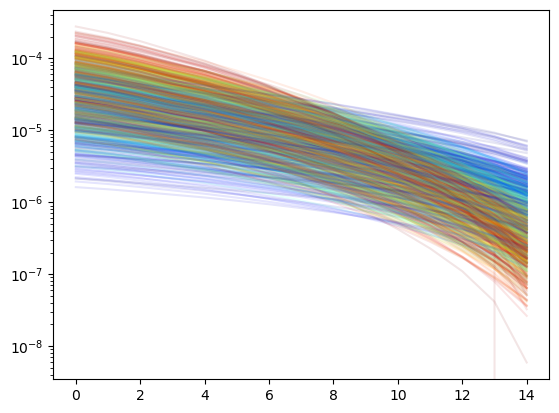

In [9]:
base_path_grid = '/e/ocean1/users/dgebauer/sbi/measurements/grid/'


theta_c = (theta[:,0] - theta[:,0].min()) / (theta[:,0].max()- theta[:,0].min())
c = plt.cm.jet(theta_c)
for i in range(0,1000, 1):
    plt.plot(xip[i,9], c=c[i], alpha=.1)
plt.yscale('log')
#plt.colorbar(mappable=c)


In [10]:
xip_amp = np.sum(xip, axis=(1,2))
xip_theta_amp = np.sum(xip, axis=1)
xip_z_amp = np.sum(xip, axis=2)
xip_slope = np.gradient(xip_theta_amp, 0.01, axis=1).mean(axis=1)
xip_z_slope = np.gradient(xip_z_amp, 0.01, axis=1).mean(axis=1)

df_raw = pd.DataFrame(np.concatenate([theta, theta_fixed, xip_amp[:,None], xip_slope[:,None], xip_z_slope[:,None]], axis=1), columns=['Omega_m', 'sigma_8', 'Omega_b', 'H0', 'n_s', 'w', 'xip_amp', 'xip_slope', 'xip_z_slope'])
mutual_info_matrix(df_raw).style.format('{:.2f}').background_gradient(cmap='coolwarm', axis=None)


,Omega_m,sigma_8,Omega_b,H0,n_s,w,xip_amp,xip_slope,xip_z_slope
Omega_m,1.00,0.02,0.02,0.02,0.02,0.02,0.03,0.05,0.02
sigma_8,0.02,1.00,0.02,0.02,0.02,0.02,0.11,0.10,0.16
Omega_b,0.02,0.02,1.00,0.02,0.02,0.02,0.02,0.02,0.02
H0,0.02,0.02,0.02,1.00,0.02,0.02,0.02,0.02,0.02
n_s,0.02,0.02,0.02,0.02,1.00,0.02,0.02,0.02,0.02
w,0.02,0.02,0.02,0.02,0.02,1.00,0.02,0.02,0.02
xip_amp,0.03,0.11,0.02,0.02,0.02,0.02,1.00,0.55,0.18
xip_slope,0.05,0.10,0.02,0.02,0.02,0.02,0.55,1.00,0.16
xip_z_slope,0.02,0.16,0.02,0.02,0.02,0.02,0.18,0.16,1.00


In [11]:
df_raw.corr().style.format('{:.2e}').background_gradient(cmap='coolwarm', gmap=np.log10(np.abs(np.corrcoef(df_raw.T))), axis=None)

,Omega_m,sigma_8,Omega_b,H0,n_s,w,xip_amp,xip_slope,xip_z_slope
Omega_m,1.00e+00,-5.13e-04,1.23e-03,-1.88e-03,-6.81e-04,3.48e-03,3.88e-01,-4.37e-01,2.72e-01
sigma_8,-5.13e-04,1.00e+00,6.96e-05,-2.92e-04,3.15e-04,-5.03e-04,6.46e-01,-6.13e-01,7.97e-01
Omega_b,1.23e-03,6.96e-05,1.00e+00,2.75e-03,2.41e-03,6.71e-04,-8.89e-02,6.95e-02,-2.25e-01
H0,-1.88e-03,-2.92e-04,2.75e-03,1.00e+00,-1.52e-04,8.29e-04,-5.62e-02,3.20e-02,-9.11e-02
n_s,-6.81e-04,3.15e-04,2.41e-03,-1.52e-04,1.00e+00,5.98e-05,2.58e-02,-6.89e-03,5.47e-02
w,3.48e-03,-5.03e-04,6.71e-04,8.29e-04,5.98e-05,1.00e+00,-2.36e-02,5.70e-03,-4.36e-02
xip_amp,3.88e-01,6.46e-01,-8.89e-02,-5.62e-02,2.58e-02,-2.36e-02,1.00e+00,-9.95e-01,5.94e-01
xip_slope,-4.37e-01,-6.13e-01,6.95e-02,3.20e-02,-6.89e-03,5.70e-03,-9.95e-01,1.00e+00,-5.70e-01
xip_z_slope,2.72e-01,7.97e-01,-2.25e-01,-9.11e-02,5.47e-02,-4.36e-02,5.94e-01,-5.70e-01,1.00e+00


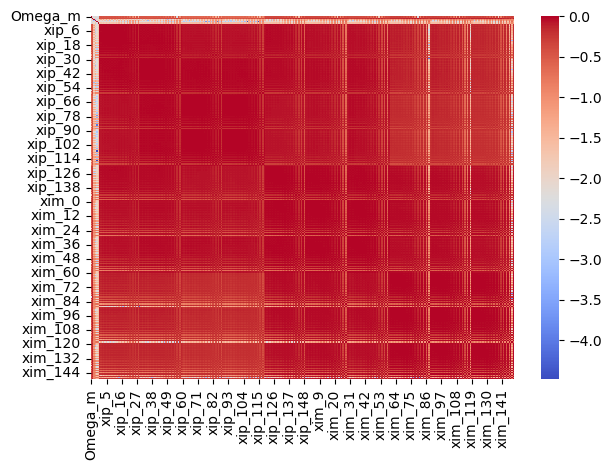

In [12]:
df_raw_full = pd.DataFrame(np.concatenate([theta[:10000], theta_fixed[:10000], xi_flat[:10000]] , axis=1), columns=['Omega_m', 'sigma_8', 'w', 'n_s', 'Omega_b', 'H0'] + [f'xip_{i}' for i in range(150)] + [f'xim_{i}' for i in range(150)])

fig, ax = plt.subplots()
sns.heatmap(df_raw_full.corr(method='pearson').apply(np.abs).apply(np.log10), cmap=plt.get_cmap('coolwarm'), cbar=True, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_xticklabels(ax.get_xticklabels(), rotation="vertical")
fig.tight_layout()